In [25]:
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import numpy as np
import os
import matplotlib.dates as mdates
import cmocean as cm
import waypoint_distance as wd

def clean_mission(file_pathway):
    """
    Clean and interpolate a glider mission.

    Returns:
        ds: full cleaned dataset (out + return)
        ds_out: outbound transect
        ds_return: return transect
    """

    ds = xr.open_dataset(file_pathway)

    # Waypoints
    waypoint_lon = np.array([-127.950, -128.115, -128.243, -128.514, -128.646, -128.798])
    waypoint_lat = np.array([51.757, 51.705, 51.715, 51.450, 51.4165, 51.408])
    central_lat = 51.715

    # Project along/across
    alongx, acrossx, _ = wd.get_simple_distance(
        shiplon=ds['longitude'].values,
        shiplat=ds['latitude'].values,
        wplon=waypoint_lon,
        wplat=waypoint_lat,
        central_lat=central_lat)
    ds = ds.assign(along=('time', alongx), across=('time', acrossx))

    # Split outbound/return
    gradient_along = np.gradient(ds['along'])
    zero_indices = np.where(gradient_along == 0)[0]
    start, end = zero_indices[0], zero_indices[-1] + 1

    out_mask = np.zeros_like(gradient_along, dtype=bool)
    return_mask = np.zeros_like(gradient_along, dtype=bool)
    out_mask[:start] = gradient_along[:start] > 0
    return_mask[end:] = gradient_along[end:] < 0

    ds_out = ds.sel(time=out_mask)
    ds_return = ds.sel(time=return_mask)

    # Remove loops
    for subset in [ds_out, ds_return]:
        prev_len = -1
        while prev_len != len(subset['time']):
            prev_len = len(subset['time'])
            grad = np.gradient(subset['along'])
            keep_mask = grad > 0 if subset is ds_out else grad < 0
            subset = subset.sel(time=keep_mask)
        if subset is ds_out:
            ds_out = subset
        else:
            ds_return = subset

    # Interpolate
    ds_out = interpolate(ds_out.set_coords('along'))
    ds_return = interpolate(ds_return.set_coords('along'))
    
    return ds_out, ds_return

def interpolate(ds):
    """
    Interpolate the dataset to a regular grid along the 'along' dimension.
    """
    # Drop duplicate 'along' values
    _, index_unique = np.unique(ds['along'], return_index=True)
    ds = ds.isel(time=index_unique)

    # Create mission-specific along grid
    min_along = np.floor(ds['along'].min().item() / 200) * 200
    max_along = np.ceil(ds['along'].max().item() / 200) * 200
    along_grid = np.arange(min_along, max_along + 1, 200)

    # Swap and interpolate
    ds = ds.swap_dims({'time': 'along'})
    ds_interp = ds.interp(along=along_grid)

    # Interpolate time (linearly)
    interp_time = np.interp(
        along_grid,
        ds['along'].values,
        ds['time'].values.astype('datetime64[ns]').astype('float64'),
        left=np.nan,
        right=np.nan
    )
    ds_interp['time'] = ('along', interp_time.astype('datetime64[ns]'))

    return ds_interp

def append_to_calvert_cube(ds_transect, cube_path='~/Desktop/calvert_cube.nc', source_file=None):
    cube_path = os.path.expanduser(cube_path)

    # Ensure transect dim exists
    if 'transect' not in ds_transect.dims:
        ds_transect = ds_transect.expand_dims(transect=[0])

    # Add transect_time using first valid timestamp
    if 'transect_time' not in ds_transect.coords:
        time_vals = ds_transect['time'].values
        valid_times = time_vals[~np.isnan(time_vals.astype('datetime64[ns]').astype('float64'))]
        transect_time = np.datetime64(valid_times[0]) if len(valid_times) > 0 else np.datetime64('NaT')
        ds_transect = ds_transect.assign_coords(transect_time=('transect', [transect_time]))

    # Add source file tag
    if source_file:
        ds_transect.attrs['source_file'] = os.path.basename(source_file)

    # If cube doesn't exist, write the first transect
    if not os.path.exists(cube_path):
        ds_transect.attrs['source_file'] = [os.path.basename(source_file)]
        ds_transect.to_netcdf(cube_path)
        print(f"Created new cube: {cube_path}")
        return

    # Load existing cube
    cube = xr.open_dataset(cube_path)
    cube.load(); cube.close()

    # Check if file is already in the cube
    processed_files = cube.attrs.get('source_file', [])
    if isinstance(processed_files, str):
        processed_files = [processed_files]
    if os.path.basename(source_file) in processed_files:
        print(f"Skipping {source_file}: already in cube.")
        return

    # Assign new transect index
    new_index = cube.sizes['transect']
    ds_transect = ds_transect.assign_coords(transect=[new_index])
    ds_combined = xr.concat([cube, ds_transect], dim='transect')

    # Update cube-level metadata
    ds_combined.attrs['source_file'] = processed_files + [os.path.basename(source_file)]
    ds_combined.to_netcdf(cube_path, mode='w')
    print(f"Appended to cube: {source_file}")


def add_file_to_cube(filepath):
    ds_out, ds_return = clean_mission(filepath)
    append_to_calvert_cube(ds_out, source_file=filepath + "_out")
    append_to_calvert_cube(ds_return, source_file=filepath + "_return")

In [26]:
# 'Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200717_grid_delayed.nc'
# '/Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200810_grid_delayed.nc'
# '/Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200908_grid_delayed.nc'
# '/Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20210324_grid_delayed.nc'
# '/Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20210511_grid_delayed.nc',

In [27]:
import os

cube_path = os.path.expanduser('~/Desktop/calvert_cube.nc')

if os.path.exists(cube_path):
    os.remove(cube_path)
    print(f"Deleted: {cube_path}")
else:
    print("Cube does not exist.")

Deleted: /Users/martinwilliamson/Desktop/calvert_cube.nc


In [28]:
import glob
import os
# Path to directory containing the missions
data_dir = '/Users/martinwilliamson/CalvertLine_reprocessed'

# Grab all *_grid_delayed.nc files
nc_files = sorted(glob.glob(os.path.join(data_dir, '*_grid_delayed.nc')))

for f in nc_files:
    print(f"Trying {f}")
    add_file_to_cube(f)

cube = xr.open_dataset('/Users/martinwilliamson/Desktop/calvert_cube.nc')
cube

Trying /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200717_grid_delayed.nc
Created new cube: /Users/martinwilliamson/Desktop/calvert_cube.nc
Appended to cube: /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200717_grid_delayed.nc_return
Trying /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200810_grid_delayed.nc
Appended to cube: /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200810_grid_delayed.nc_out
Appended to cube: /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200810_grid_delayed.nc_return
Trying /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200908_grid_delayed.nc
Appended to cube: /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200908_grid_delayed.nc_out
Appended to cube: /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20200908_grid_delayed.nc_return
Trying /Users/martinwilliamson/CalvertLine_reprocessed/dfo-bb046-20210324_grid_delayed.nc
Appended to cube: /Users/martinwilliamso

<xarray.Dataset> Size: 607MB
Dimensions:                (transect: 10, depth: 1100, along: 383)
Coordinates:
  * depth                  (depth) float64 9kB 0.5 1.5 2.5 ... 1.098e+03 1.1e+03
  * along                  (along) float64 3kB 600.0 800.0 ... 7.68e+04 7.7e+04
  * transect               (transect) int64 80B 0 1 2 3 4 5 6 7 8 9
    profile                (transect, along) float64 31kB ...
    longitude              (transect, along) float64 31kB ...
    latitude               (transect, along) float64 31kB ...
    transect_time          (transect) datetime64[ns] 80B ...
Data variables: (12/21)
    heading                (transect, depth, along) float64 34MB ...
    pitch                  (transect, depth, along) float64 34MB ...
    roll                   (transect, depth, along) float64 34MB ...
    conductivity           (transect, depth, along) float64 34MB ...
    temperature            (transect, depth, along) float64 34MB ...
    pressure               (transect, depth, along) float64 34MB ...
    ...                     ...
    potential_density      (transect, depth, along) float64 34MB ...
    density                (transect, depth, along) float64 34MB ...
    potential_temperature  (transect, depth, along) float64 34MB ...
    mission_number         (transect) int32 40B ...
    across                 (transect, along) float64 31kB ...
    time                   (transect, along) datetime64[ns] 31kB ...
Attributes: (12/66)
    Conventions:               CF-1.8
    Metadata_Conventions:      CF-1.6, Unidata Dataset Discovery v1.0
    acknowledgement:           Funding from Fisheries and Oceans Canada, Cana...
    comment:                   Calvert Island deployment
    contributor_name:          James Pegg, Jody Klymak, Tetjana Ross, Hayley ...
    contributor_role:          Lead Technician, Principal Investigator, Co-PI...
    ...                        ...
    time_coverage_end:         2020-08-06T21:32:24
    time_coverage_start:       2020-07-17T16:28:43
    title:                     dfo-bb046-20200717T1628
    transmission_system:       IRIDIUM
    wmo_id:                    4803918
    source_file:               ['dfo-bb046-20200717_grid_delayed.nc_out', 'df...

In [30]:
def plot_all_sections(cube, temp_bounds=(4, 16)):
    import matplotlib.pyplot as plt
    import numpy as np
    import cmocean as cm

    n = cube.sizes['transect']
    cmap = cm.cm.thermal

    for i in range(n):
        ds = cube.isel(transect=i)

        temperature = ds['temperature'].values
        pdens = ds['potential_density'].values - 1000  # sigma-theta
        along = ds['along'].values
        depth = ds['depth'].values
        import pandas as pd
        raw_time = ds['transect_time'].values
        transect_time = pd.to_datetime(raw_time).strftime('%Y-%m-%d') if pd.notnull(raw_time) else "Unknown Date"

        fig, ax = plt.subplots(figsize=(12, 6))
        cf = ax.pcolormesh(along / 1000, depth, temperature, cmap=cmap,
                           shading='auto', vmin=temp_bounds[0], vmax=temp_bounds[1])

        # Isopycnal contours
        for levels, color, lw in [
            (np.linspace(24, 27, 7), 'black', 0.5),
            ([26.6], 'white', 2)]:
            cf_iso = ax.contour(along / 1000, depth, pdens,
                                levels=levels, colors=color, linewidths=lw)
            if lw != 0.3:
                ax.clabel(cf_iso, fmt='%1.2f')

        ax.set_ylim(410, 0)
        ax.set_xlim(0, 77)
        ax.set_xlabel("Along-Transect Distance (km)")
        ax.set_ylabel("Depth (m)")
        ax.set_title(f"Temperature Section – Transect {i} ({transect_time})")
        plt.colorbar(cf, ax=ax, label='Temperature (°C)')
        plt.tight_layout()
        plt.show()

In [33]:
cube['transect_time'].values

array(['NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT', 'NaT',
       'NaT'], dtype='datetime64[ns]')

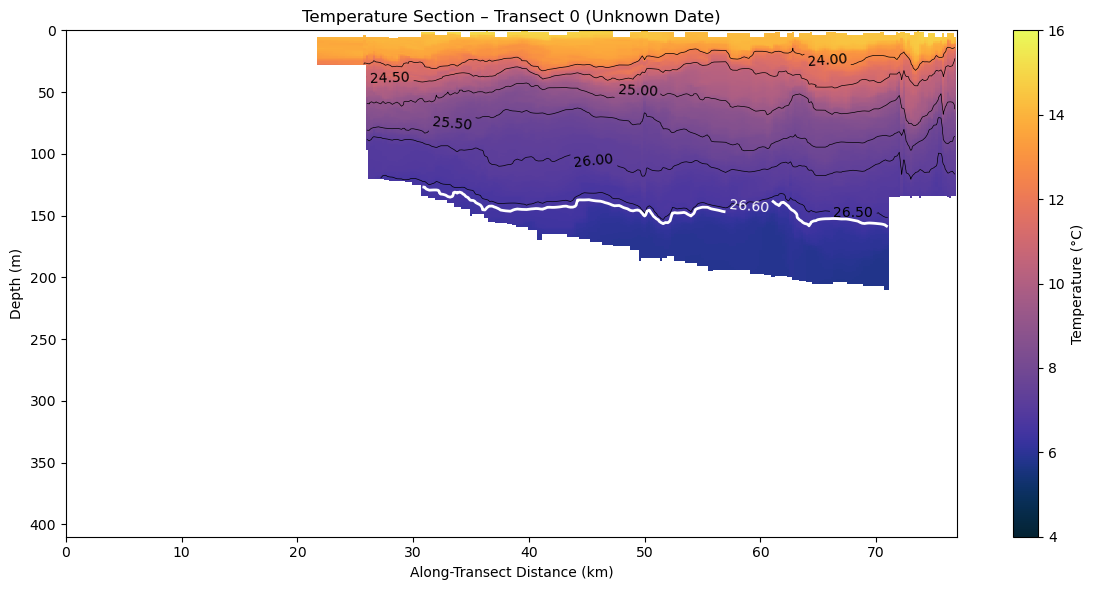

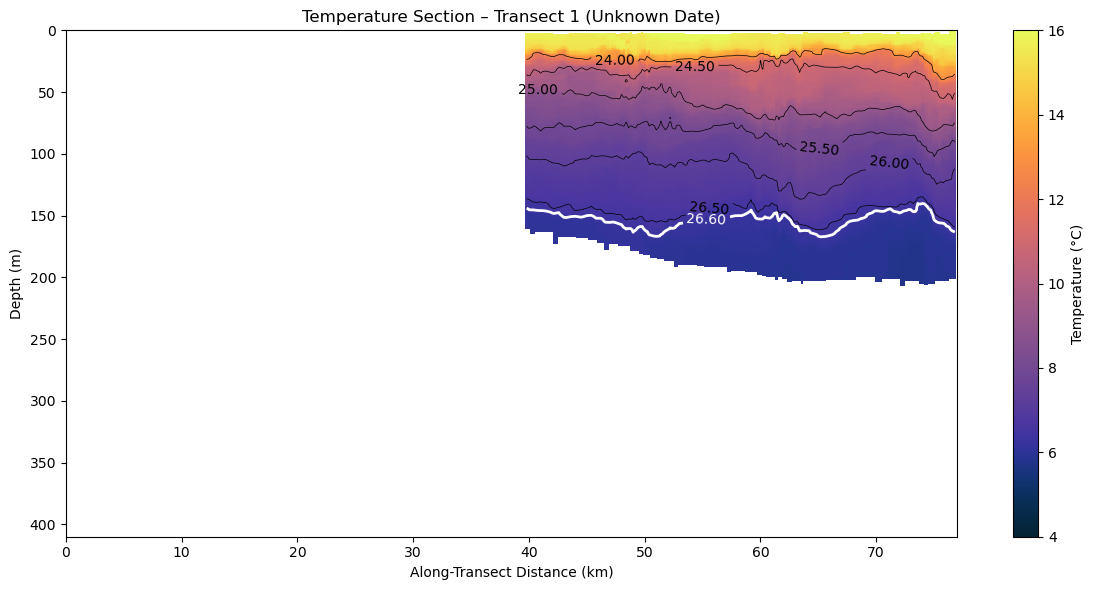

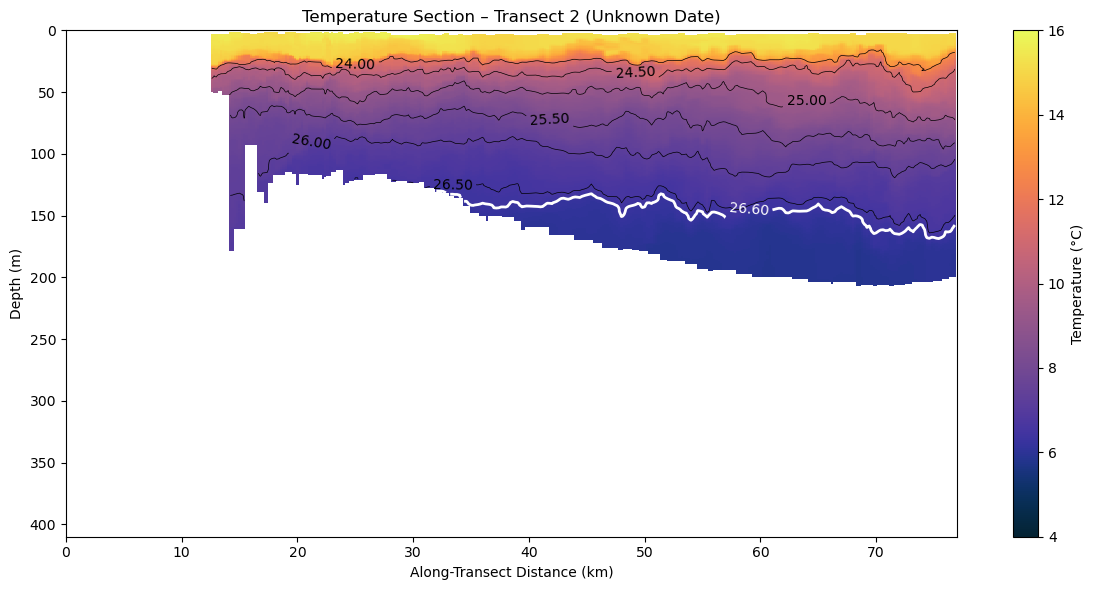

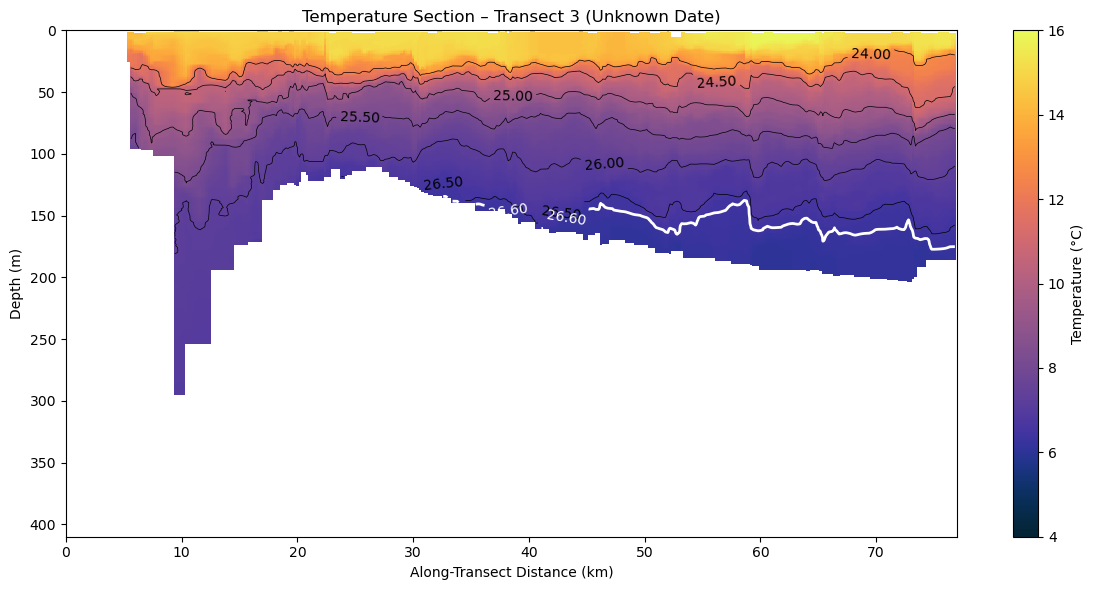

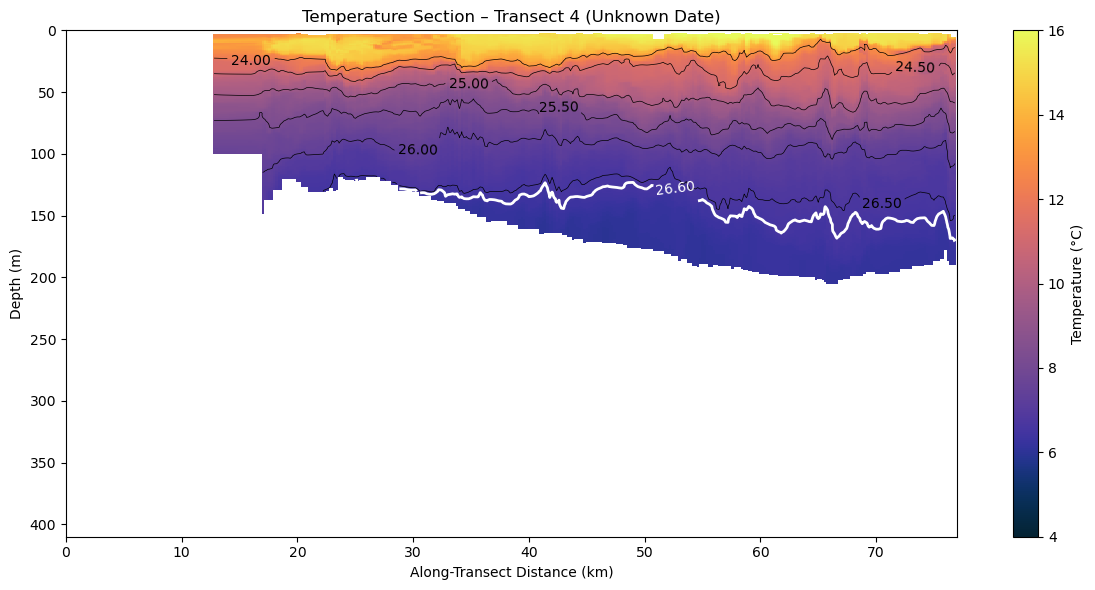

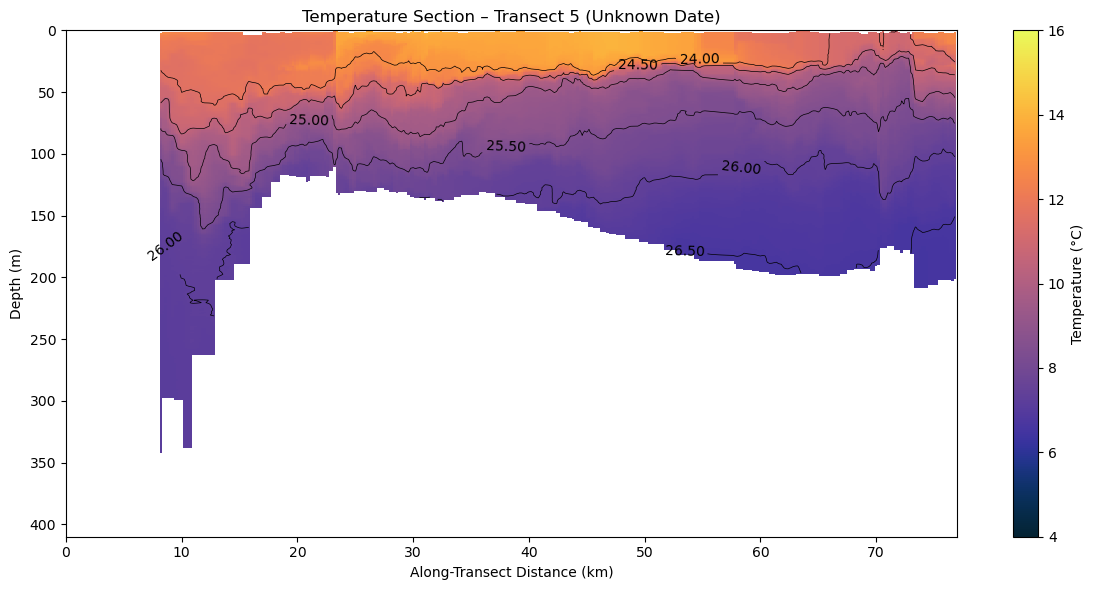

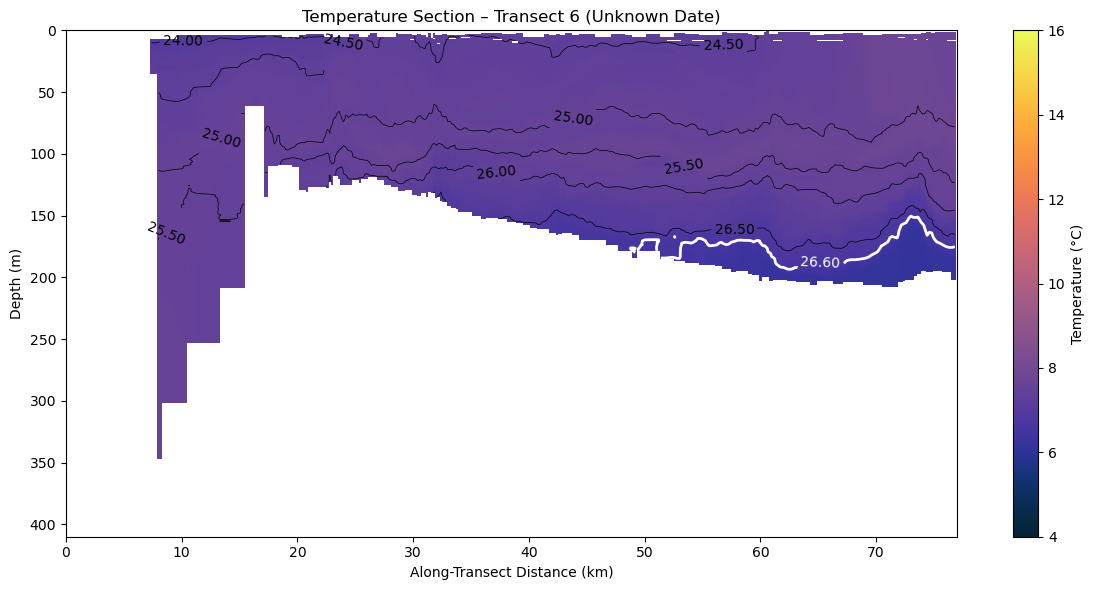

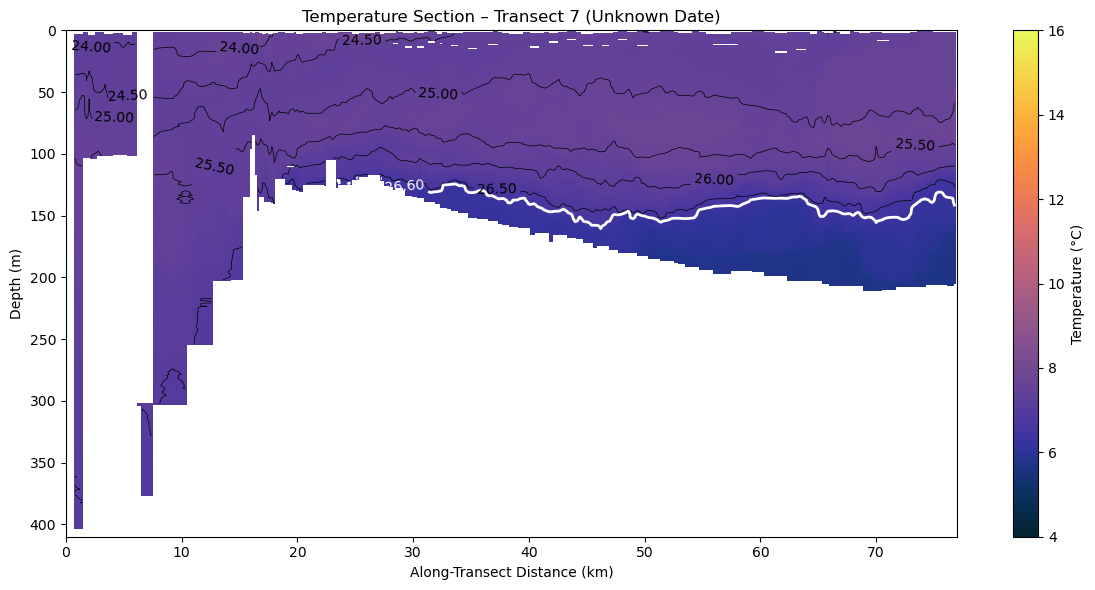

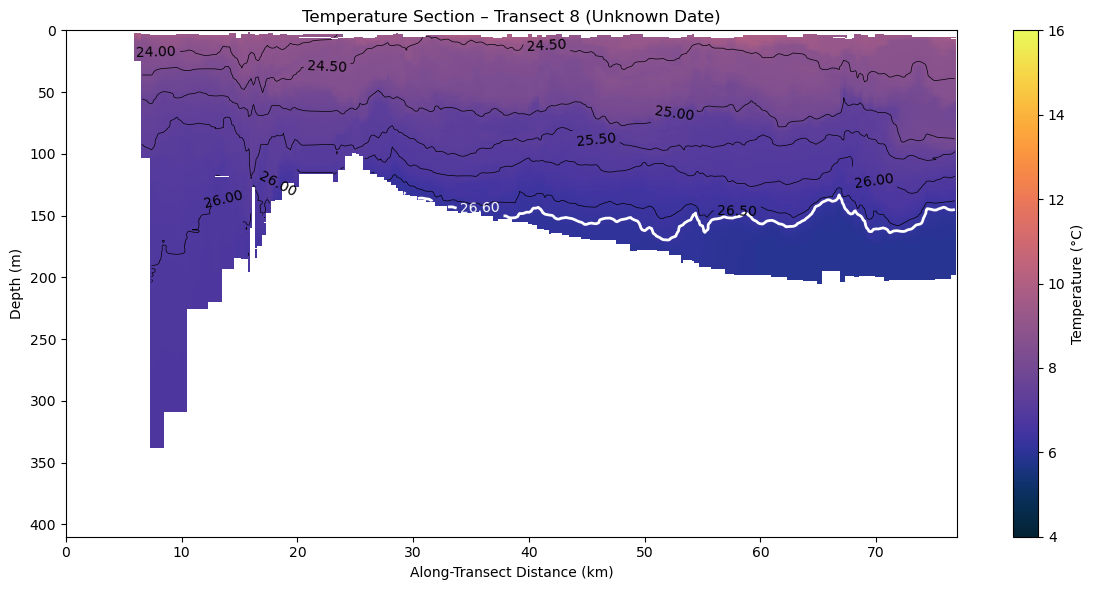

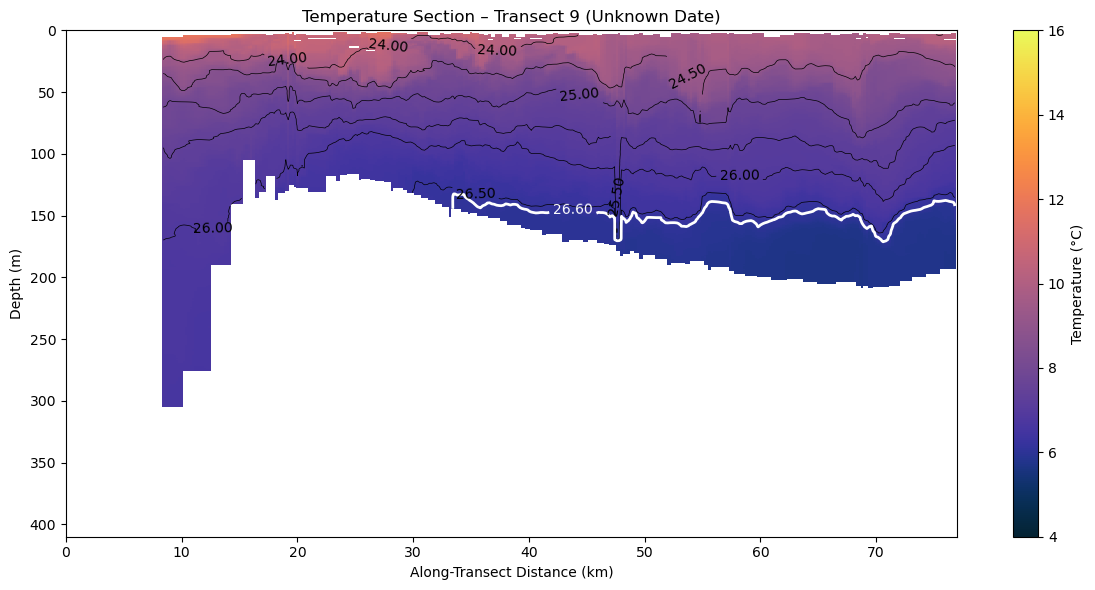

In [32]:
plot_all_sections(cube)